In [141]:
import tulip as tlp
from tulip.interfaces import omega as omega_int
from tulip import transys, abstract, spec, synth
from visualization import graph_builder as gb
import networkx as nx
from tulip.transys import machines
from GR1_defaults import settings

from tulip import dumpsmach
import pickle

from omega.games import enumeration as enum

In [142]:
path = 'left_turn/'

In [143]:
# System definition
sys = tlp.transys.FTS()

sys.atomic_propositions.add_from({'a4', 'a7', 'a8', 'a9'})
sys.states.add('c4', ap={'a4'})
sys.states.add('c7', ap={'a7'})
sys.states.add('c8', ap={'a8'})
sys.states.add('c9', ap={'a9'})
sys.states.initial.add('c7')    # start in state c7

sys.transitions.add_comb({'c7'}, {'c7', 'c8'})
sys.transitions.add_comb({'c8'}, {'c8', 'c4'})
sys.transitions.add_comb({'c4'}, {'c4', 'c9'})
sys.transitions.add_comb({'c9'}, {'c9'})

In [144]:
# Variables
env_vars = {'vh': (2, 6), 
            'light': ["g1", "g2", "g3", "y1", "y2", "r"]}
sys_vars = {}

In [145]:
# Initialization
env_init = {'vh = 2',
            'light = "g1"'}
sys_init = {}

In [146]:
# Safety
env_safe = {
    # Human vehicle movement
    'vh = 2 -> next(vh) = 2 | next(vh) = 3',
    'vh = 3 -> next(vh) = 3 | next(vh) = 4',
    'vh = 4 -> next(vh) = 4 | next(vh) = 5',
    'vh = 5 -> next(vh) = 5 | next(vh) = 6',
    'vh = 6 -> next(vh) = 6',
    # Traffic light
    'light = "g1" -> next(light = "g2")',
    'light = "g2" -> next(light = "g3")',
    'light = "g3" -> next(light = "y1")',
    'light = "y1" -> next(light = "y2")',
    'light = "y2" -> next(light = "r")',
    'light = "r" -> next(light = "r") | next(light = "g1")',
    # Human vehicle does not run a red
    '!(light = "r" & (vh = 4 | vh = 5))'
}
sys_safe = {
    # No collision with human vehicle
    '!(a4 & vh = 4)',
    # No running a red
    '!(light="r" & (a4 || a8))' #,
    # No being collided into by the human vehicle
    # Commenting this out means that we are considering the game as having simultaneous updates
    # '!(a4 & X(vh = 4))'
}

In [147]:
# Progress
env_prog = {'vh = 6',
            'light = "g1"'}
sys_prog = {'a9'}
    

specs = settings.set_specs(env_vars, sys_vars, env_init, sys_init,
                        env_safe, sys_safe, env_prog, sys_prog)
print(specs.pretty())

spec = tlp.synth._spec_plus_sys(specs, None, sys, False, False)
# Automaton class found in omega/omega/symbolic/temporal.py
aut = omega_int._grspec_to_automaton(spec)

ENVIRONMENT VARIABLES:
	vh	(2, 6)
	light	['g1', 'g2', 'g3', 'y1', 'y2', 'r']

SYSTEM VARIABLES:
	(none)

FORMULA:
ASSUMPTION:
    INITIAL
	  (light = "g1")
	& (vh = 2)
    SAFETY
	  [](vh = 2 -> next(vh) = 2 | next(vh) = 3)
	& [](vh = 6 -> next(vh) = 6)
	& [](vh = 3 -> next(vh) = 3 | next(vh) = 4)
	& [](light = "g2" -> next(light = "g3"))
	& [](light = "y1" -> next(light = "y2"))
	& [](light = "y2" -> next(light = "r"))
	& [](light = "g3" -> next(light = "y1"))
	& [](light = "r" -> next(light = "r") | next(light = "g1"))
	& [](light = "g1" -> next(light = "g2"))
	& [](vh = 4 -> next(vh) = 4 | next(vh) = 5)
	& [](vh = 5 -> next(vh) = 5 | next(vh) = 6)
	& [](!(light = "r" & (vh = 4 | vh = 5)))
    LIVENESS
	  []<>(vh = 6)
	& []<>(light = "g1")
GUARANTEE:
    SAFETY
	  [](!(a4 & vh = 4))
	& [](!(light="r" & (a4 || a8)))
    LIVENESS
	  []<>(a9)



In [148]:
# Synthesize the controller
ctrl = tlp.synth.synthesize(specs, sys=sys)
assert ctrl is not None, 'unrealizable'
with open(path + "ctrl", "wb") as file:
    pickle.dump(ctrl, file)

dumpsmach.write_python_case(path + 'controller.py', ctrl, classname="sys_ctrl")

removed 6 nodes from 46 total


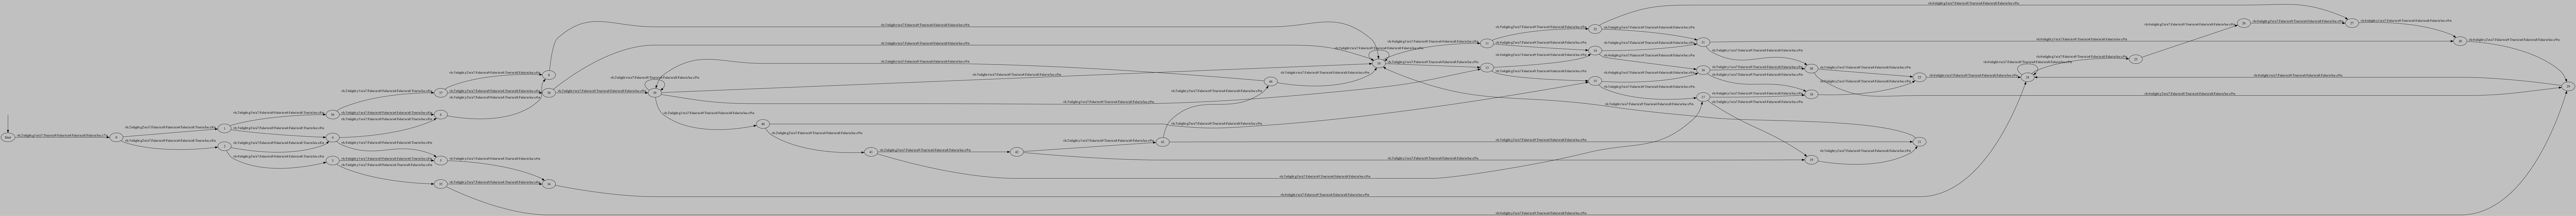

True

In [149]:
ctrl.plot()

In [150]:
# spec = tlp.synth._spec_plus_sys(specs, None, sys, False, False)
# # Automaton class found in omega/omega/symbolic/temporal.py
# aut = omega_int._grspec_to_automaton(specs)

In [151]:
# enum.action_to_steps(aut, env='env', sys='sys',qinit=aut.qinit)

In [152]:
# enum.action_to_steps(aut, env='env', sys='sys')

In [153]:
# enum.action_to_steps(aut, env='env', sys='impl')

In [154]:
# Graphing
filename = path + "graph"
attributes = ['color', 'shape']

# Making a graph of the asynchronous GR(1) game with deadends.
g0 = gb.game_graph(aut, env='env', sys='sys', remove_deadends=False, append_non_visited=False, qinit=aut.qinit)
h0 = gb._game_format_nx(g0, attributes)
pd0 = nx.drawing.nx_pydot.to_pydot(h0)
pd0.write_pdf(path + 'game.pdf')
with open(filename, "wb") as file:
    pickle.dump(g0, file)

about to create game graph
found winning set
before queue


# Trying to satisfy the environment's liveness/progress conditions

In [155]:
# making environment progress conditions into a dictionary
env_prog_dict = {}
for elem in env_prog:
    split_lst = elem.split(' = ')
    key = split_lst[0]
    if len(split_lst) == 1:
        env_prog_dict[key] = True
    elif type(env_vars[key]) == list:
        value = split_lst[1]
        env_prog_dict[key] = env_vars[key].index(value[1:len(value)-1])
    else:
        env_prog_dict[key] = int(split_lst[1])


In [156]:
env_prog_dict

{'vh': 6, 'light': 0}

In [157]:
# find the nodes in the graph that satisfy any of the environment's progress conditions
# each entry in the dictionary is a list of nodes that satisfying each progress condition
env_prog_nodes = {}
for item in env_prog_dict.items():
    env_prog_nodes[item] = []
for node in g0.nodes:
    for item in env_prog_dict.items():
        if item in g0.nodes[node].items():
            env_prog_nodes[item].append(node)

In [158]:
# find all the simple cycles in g0
cycles = list(nx.simple_cycles(g0))

In [189]:
cycles

[[184, 182],
 [34, 36, 4, 6, 10, 12, 16, 18, 22, 24, 28, 30],
 [28, 30],
 [64, 66, 67, 69, 43, 45, 49, 51, 55, 57, 61, 63],
 [57, 55],
 [192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 191],
 [196, 197],
 [128, 131, 132, 135, 136, 139, 140, 142, 120, 123, 124, 127],
 [131, 132],
 [74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85],
 [75, 76]]

In [159]:
# Filter cycles that contain nodes that satisfy each type of progress condition
prog_satisfying_cycles = []
for cycle in cycles:
    satisfies_prog_counter = 0
    for lst in env_prog_nodes.values():
        for node in lst:
            if node in cycle:
                satisfies_prog_counter += 1
                break
    if satisfies_prog_counter == len(env_prog_dict.values()):
        prog_satisfying_cycles.append(cycle)

In [160]:
prog_satisfying_cycles

[[64, 66, 67, 69, 43, 45, 49, 51, 55, 57, 61, 63],
 [74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85]]

In [ ]:
# see if any of these cycles can have the system leave the cycle (with no return)

In [161]:
def is_prefix(list1, list2):
    # Compare the elements of both lists up to the length of the shorter list
    min_length = min(len(list1), len(list2))
    for i in range(min_length):
        if list1[i] != list2[i]:
            return False
    return True

In [184]:
# Find all the paths from the initial node(s) to the cycles satisfying the progress conditions
# ASSUMPTION: g0.nodes[0] is the ONLY initial node
paths_to_cycle = []
for cycle in prog_satisfying_cycles:
    for node in cycle:
        new_paths = list(nx.all_simple_paths(g0, 0, node))
        # I do not want to have 2 paths, one of which is a subset of the other. 
        # I just want the subset.
        for new_path in new_paths[:]:
            for existing_path in paths_to_cycle[:]:
                if is_prefix(new_path, existing_path):
                    if len(new_path) < len(existing_path):
                        paths_to_cycle.remove(existing_path)
                    else:
                        new_paths.remove(new_path)
                        break
        paths_to_cycle += new_paths

new problem: This does not take into account that the system may take some action 
that will take us away from one of these paths. Do we have to care?
Yes. We want to always satisfy the liveness conditions, no matter what the system does.

Should I do some winning set calculations? I can't just use the winning set 
functions because I want to use the GR1 graph that contains the actions the 
system can take that satisfy its winning condition. 

Okay let's say that there is a safe action that the system can take but will lead to
the environment taking the system to a red node. Is that in our graph? No... it does not seem so.
Wouldn't we want a hard test to find this case? Do we just assume that the system has failed at this point?

okay so should we just assume the graph is ideal
and then figure out the paths that allow the environment to satisfy its progress conditions,
regardless of what the system does

In [187]:
len(paths_to_cycle)

7505

In [188]:
paths_to_cycle

[[0,
  1,
  3,
  173,
  175,
  176,
  178,
  179,
  181,
  182,
  184,
  34,
  36,
  4,
  6,
  10,
  12,
  16,
  18,
  22,
  24,
  28,
  30,
  31,
  33,
  160,
  162,
  67],
 [0,
  1,
  3,
  173,
  175,
  176,
  178,
  179,
  181,
  182,
  184,
  28,
  30,
  31,
  33,
  160,
  162,
  67],
 [0, 1, 3, 173, 175, 176, 178, 179, 181, 28, 30, 31, 33, 160, 162, 67],
 [0, 1, 3, 173, 175, 176, 178, 22, 24, 28, 30, 31, 33, 160, 162, 67],
 [0, 1, 3, 173, 175, 16, 18, 22, 24, 28, 30, 31, 33, 160, 162, 67],
 [0, 1, 3, 10, 12, 16, 18, 22, 24, 28, 30, 31, 33, 160, 162, 67],
 [0, 4, 6, 10, 12, 16, 18, 22, 24, 28, 30, 31, 33, 160, 162, 67],
 [0, 1, 3, 173, 175, 176, 178, 179, 181, 182, 184, 34, 36, 37, 39, 40, 42, 43],
 [0,
  1,
  3,
  173,
  175,
  176,
  178,
  179,
  181,
  182,
  184,
  34,
  36,
  4,
  6,
  10,
  12,
  16,
  18,
  22,
  24,
  28,
  30,
  31,
  33,
  37,
  39,
  40,
  42,
  43],
 [0,
  1,
  3,
  173,
  175,
  176,
  178,
  179,
  181,
  182,
  184,
  34,
  36,
  4,
  6,
  10,
  12,

Should I make a graph that adds a transition from one env node to another only if all system actions from 
the env node go to the other

Then, I do the same code on this

Wait, I should do it on sets. Only if all system actions from the env node go to a winning set lol
